In [102]:
# imports
import os, platform, glob, csv, cv2
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, Dropout
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

def read_sim_logs(csv_paths):
    """
    Reads each `.csv` file and stores the image file paths and measurement values to a list of dictionaries.
    :param csv_paths: list of file paths to CSV files created by the simulator.
    :return: list of dictionaries containing image files and measurements from the simulator at each sample.
    """
    log_file_name = 'driving_log.csv'
    
    lines = []
    labels = []
    filenames = []
    if not isinstance(csv_paths, list):
        csv_paths = [csv_paths]
    for i_path, path in enumerate(csv_paths):
        csv_file_path = os.path.join(path, log_file_name)
        print('Loading data from "{}"...'.format(csv_file_path))
        img_path = path +"IMG/"
        print(path)
        with open(csv_file_path, 'rt') as f:
            reader = csv.reader(f, delimiter=',')
            for line in reader:
                if line is None:
                    # empty line
                    continue
                lines.append(line)
                
                center_image_path = os.path.join(img_path,  line[0].split('/')[-1])
                left_image_path = os.path.join(img_path,  line[1].split('/')[-1])
                right_image_path = os.path.join(img_path,  line[2].split('/')[-1])

                center_angle = float(line[3])
                left_angle = center_angle + angle_correction
                right_angle = center_angle - angle_correction

                labels.extend([center_angle, left_angle, right_angle])
                filenames.extend([center_image_path, left_image_path, right_image_path])
    return lines, filenames, labels

def read_image(log_path, path_to_imgs):
    image_path = get_image_path(log_path, path_to_imgs)
    # cv2 reads to BGR
    return cv2.imread(image_path)

def image_normalization(pixel_value):
    # image normalization for pixel values to be zero mean and SD of 1
    result = pixel_value / 255.0 - 0.5
    return result

def sim_model(act='elu', d=0.5, debug=False):
    model = Sequential()
    model.add(Cropping2D(cropping=((65, 25), (0, 0)), input_shape=(160, 320, 3)))
    model.add(Lambda(normalize_pixels, output_shape=(70, 320, 3)))
    if debug:
        model.add(Flatten())
        model.add(Dense(1))
        return model
    model.add(Conv2D(24, (5,5), strides=(2,2), activation=act))
    model.add(Dropout(d))
    model.add(Conv2D(36, (5,5), strides=(2,2), activation=act))
    model.add(Dropout(d))
    model.add(Conv2D(48, (5,5), strides=(2,2), activation=act))
    model.add(Dropout(d))
    model.add(Conv2D(64, (3,3), activation=act))
    model.add(Dropout(d))
    model.add(Conv2D(64, (3,3), activation=act))
    model.add(Dropout(d))
    model.add(Flatten())
    model.add(Dense(100, activation=act))
    model.add(Dropout(d))
    model.add(Dense(50, activation=act))
    model.add(Dropout(d))
    model.add(Dense(10, activation=act))
    model.add(Dense(1))
    return model

def augmented_image(image, label, proba=0.5):
    ''' 
    method for adding random distortion to dataset images, including random brightness adjust, and a random
    vertical shift of the horizon position
    '''
    new_img = image.astype(float)
    # 1) randomly flip image horizontally and reverse label
    if np.random.rand() > proba:
        new_img = cv2.flip(new_img, 1)
        label = -label
    # 2) random brightness
    new_img = brighten_image(new_img)
    # 3) random shadow
    new_img = shadow_image(new_img)
    # 4) random horizon shift
    new_img = shift_horizon(new_img)
    return new_img.astype(np.uint8), label


In [3]:
# columen: [center image/ left image/ right image/ steering[-1,1]/ throttle[0,1]/ break[always 0] /speed[0,30]] 
# read the image from the given paths in driving_log.csv
import os, platform, glob, csv, cv2
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, Dropout
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

FilePath = ['C:\\Users\\hsiny\\GitHub\\data\\Hans_track2_t2\\driving_log.csv',
            'C:\\Users\\hsiny\\GitHub\\data\\Hans_track2\\driving_log.csv',
            'C:\\Users\\hsiny\\GitHub\\data\\Hans_track1\\driving_log.csv', ]

current_path = ['C:\\Users\\hsiny\\GitHub\\data\\Hans_track2_t2\\IMG\\',
                'C:\\Users\\hsiny\\GitHub\\data\\Hans_track2\\IMG\\',
                'C:\\Users\\hsiny\\GitHub\\data\\Hans_track1\\IMG\\',]

images =[]
measurements=[]
correction=0.3
for j in range(3):
    lines=[]
    with open(FilePath[j]) as csvfile:
        spamreader = csv.reader(csvfile)        
        for line in spamreader:
            lines.append(line)
        csvfile.close()
        for line in lines: 
            for i in range(3):
                factor=[0, 1, -1]
                source_path = line[i]
                filename = source_path.split('/')[-1]
                current_paths = current_path[j] + filename 
                image=cv2.imread(current_paths)
                #image=cv2.imread(current_paths, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                measurement = float(line[3])
                measurements.append(round(measurement + factor[i]*correction,3)) 

augmented_images, augmented_measurements = [],[]
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*(-1))


In [4]:
print([len(augmented_images), len(augmented_measurements)])

[28026, 28026]


In [13]:
augmented_images[10000].shape

(160, 320, 3)

In [280]:
augmented_measurements[1000]

0.35

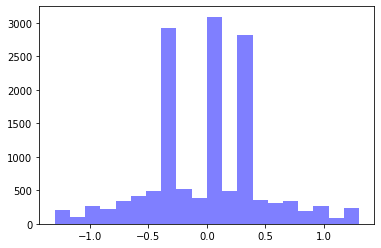

In [5]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

num_bins = 20
n, bins, patches = plt.hist(measurements, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [ ]:
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)
model = Sequential()
model.add(Cropping2D(cropping=((65, 25), (0, 0)), input_shape=(160, 320, 3)))
model.add(Lambda(lambda x: x/255 -0.5, output_shape=(70, 320, 3)))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, batch_size=128 ,epochs=5)

model.save('model.h5')


Epoch 1/5
28026/28026 [==============================] - 11s 409us/step - loss: 0.3829
Epoch 2/5
 7296/28026 [======>.......................] - ETA: 8s - loss: 0.1734

In [6]:
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples), validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

NameError: name 'train_generator' is not defined

In [143]:
# columen: [center image/ left image/ right image/ steering[-1,1]/ throttle[0,1]/ break[always 0] /speed[0,30]] 
# read the image from the given paths in driving_log.csv
import os, platform, glob, csv, cv2
import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, Dropout, AveragePooling2D, MaxPooling2D
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline


FilePath = 'C:\\Users\\hsiny\\GitHub\\CarND-Behavioral-Cloning-P3\\data\\Hans_track1\\driving_log.csv'
lines=[]
with open(FilePath) as csvfile:
    spamreader = csv.reader(csvfile)
    for line in spamreader:
        lines.append(line)
images =[]
measurements=[]
for line in lines: 
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path= 'C:\\Users\\hsiny\\GitHub\\CarND-Behavioral-Cloning-P3\\data\\Hans_track1\\IMG\\' + filename 
    image=cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement) 
    
X_train = np.array(images)
y_train = np.array(measurements)

model = Sequential()
model.add(Lambda(lambda x: x/255 -0.5, input_shape=(160,320,3)))
model.add(Conv2D(filters = 6, kernel_size = 5, strides = 5, activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, strides = 2))
model.add(Conv2D(filters = 6, kernel_size = 5,strides = 5, activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, strides = 2))
model.add(Flatten())
model.add(Dense(units = 120, activation = 'relu'))
model.add(Dense(units = 84, activation = 'relu'))
model.add(Dense(units = 10, activation = 'softmax'))
#model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.compile(loss='mse',optimizer='adam')
model.fit(X_train ,y_train, epochs = 12)

model.save('model.h5')

ValueError: Error when checking target: expected dense_47 to have shape (10,) but got array with shape (1,)